# Regresión Logística vs Árboles de Decisión 

Se van a utilizar ambos modelos para predecir si hay impago o no de ciertos clientes y elegir el mejor modelo

## Lectura de Datos y EDA

In [1]:
# 1. Importar librerías
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from beautifultable import BeautifulTable as BT

from sklearn.model_selection import train_test_split as separar
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier as Arbol

In [26]:
# 2. Importar datos
df_credit_scoring = pd.read_csv('Credit Scoring.csv', encoding='latin1', delimiter = ';')
df_credit_scoring

,age,job,marital,education,default,Unnamed: 5,Unnamed: 6
0,30,unemployed,married,primary,no,NaN,NaN
1,33,services,married,secondary,no,NaN,NaN
2,35,management,single,tertiary,no,NaN,NaN
3,30,management,married,tertiary,no,NaN,NaN
4,59,blue-collar,married,secondary,no,NaN,NaN
...,...,...,...,...,...,...,...
4427,33,services,married,secondary,no,NaN,NaN
4428,57,self-employed,married,tertiary,yes,NaN,NaN
4429,57,technician,married,secondary,no,NaN,NaN
4430,28,blue-collar,married,secondary,no,NaN,NaN


In [27]:
# Se eliminan las columnas Unnamed: 5 y Unnamed: 6 que se han creado por error:
df_credit_scoring.drop(columns=['Unnamed: 5', 'Unnamed: 6'], inplace=True)

In [28]:
# EDA
for column in df_credit_scoring.columns:
    print(df_credit_scoring[column].value_counts())

age
34    231
32    224
31    199
36    188
33    186
35    180
37    161
38    159
30    150
40    142
42    141
41    135
39    130
46    119
43    115
48    114
49    112
45    112
47    108
44    105
28    103
50    101
29     97
53     94
27     94
57     91
51     91
55     90
52     86
58     85
26     77
56     74
54     71
59     71
60     47
25     44
24     24
23     20
61     16
22      9
63      8
64      7
62      7
21      7
19      4
20      3
Name: count, dtype: int64
job
management       965
blue-collar      943
technician       767
admin.           477
services         417
self-employed    183
entrepreneur     168
retired          156
unemployed       128
housemaid        109
student           84
unknown           35
Name: count, dtype: int64
marital
married     2728
single      1193
divorced     511
Name: count, dtype: int64
education
secondary    2277
tertiary     1332
primary       644
unknown       179
Name: count, dtype: int64
default
no     4356
yes      76
Nam

In [29]:
# Se van a analizar los nulos
null_counts = df_credit_scoring.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


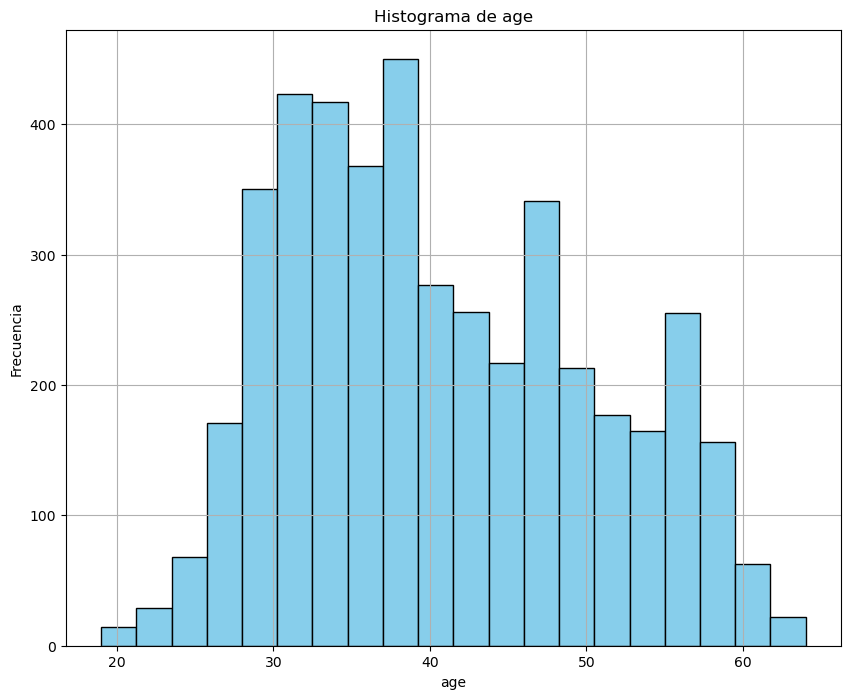

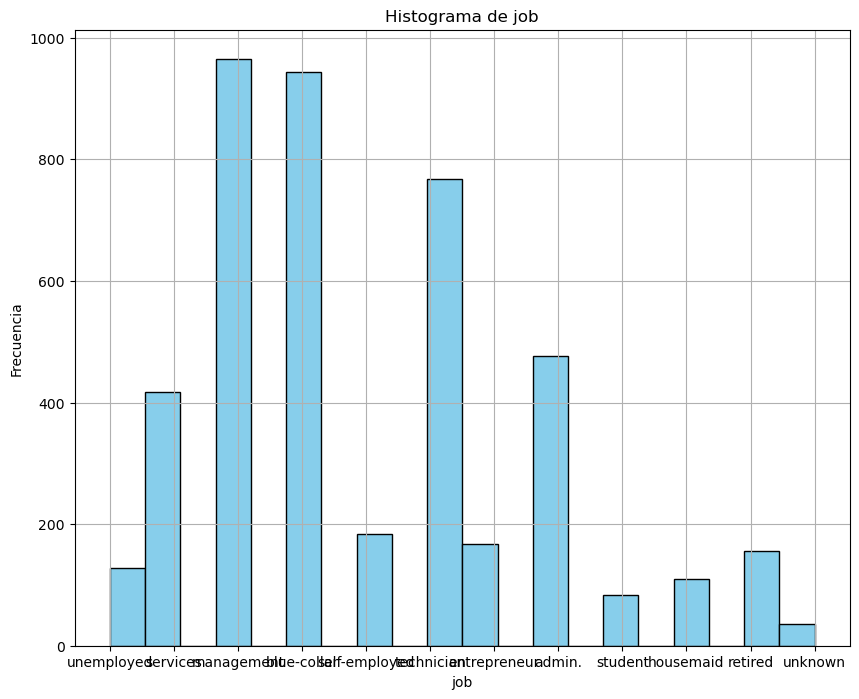

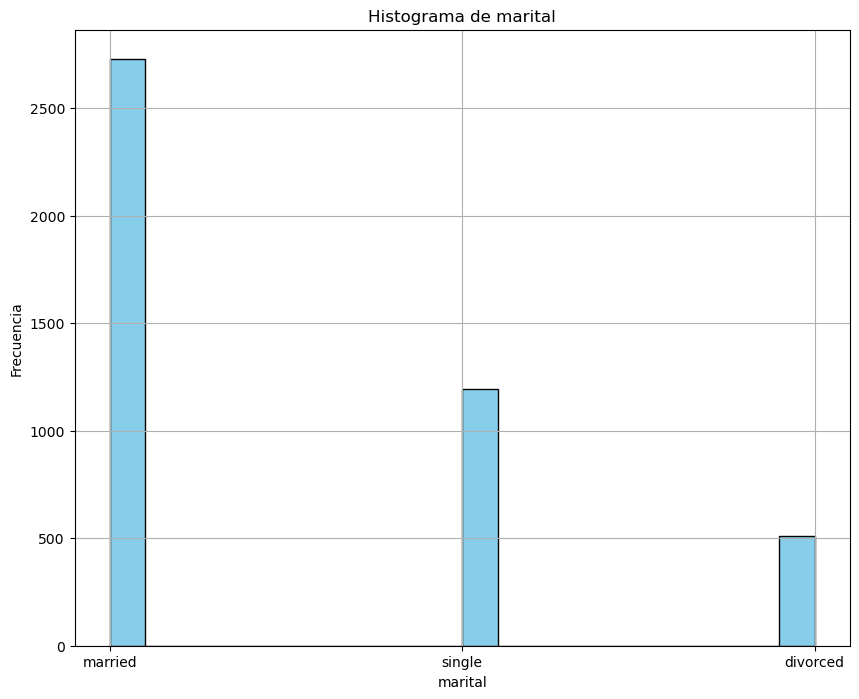

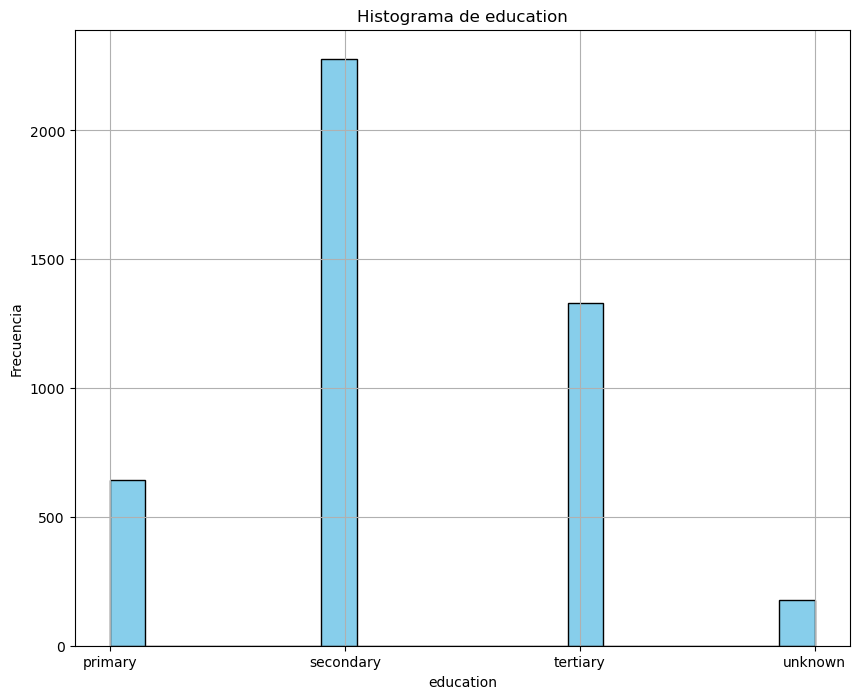

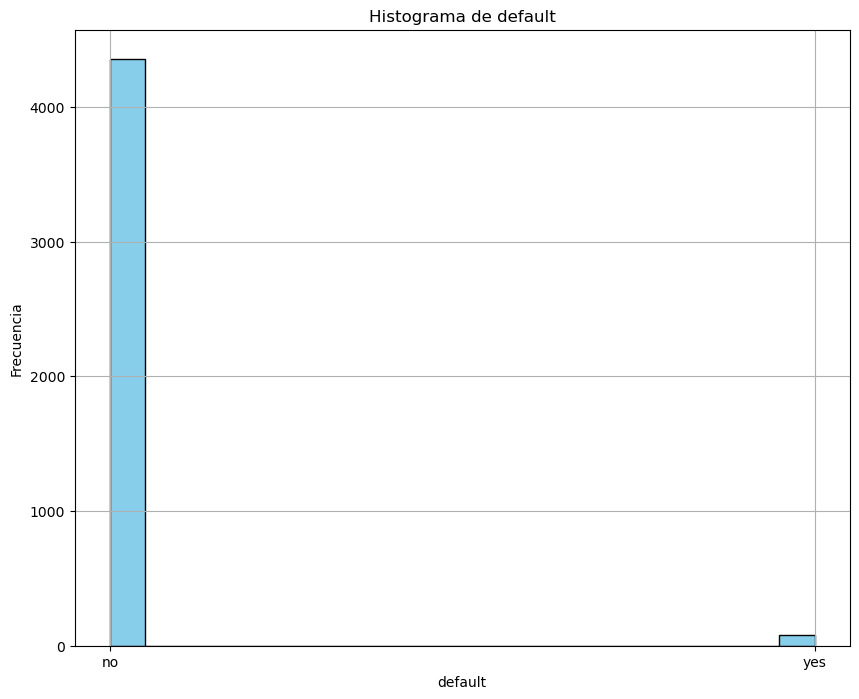

In [30]:
# Visualizar un histograma de cada columna

# Iterar sobre las columnas y crear un histograma para cada una
for column in df_credit_scoring.columns:
    plt.figure(figsize=(10, 8))  # Tamaño de la figura
    plt.hist(df_credit_scoring[column], bins=20, color='skyblue', edgecolor='black')  # Crear el histograma
    plt.title(f'Histograma de {column}')  # Título del histograma
    plt.xlabel(column)  # Etiqueta del eje x
    plt.ylabel('Frecuencia')  # Etiqueta del eje y
    plt.grid(True)  # Activar la cuadrícula
    plt.show()  # Mostrar el histograma

## Regresión Logística

In [31]:
# Variables categóricas: Encode

encoder = LabelEncoder()
df_credit_scoring_encoder = df_credit_scoring.copy()
categorical_columns = ['job', 'marital', 'education']

for column in categorical_columns:
    df_credit_scoring_encoder[column] = encoder.fit_transform(df_credit_scoring_encoder[column])
    
# Transformación de la variable objetivo default a 0 y 1
df_credit_scoring_encoder['default'] = df_credit_scoring_encoder['default'].map({'no': 0, 'yes': 1})
    
df_credit_scoring_encoder

,age,job,marital,education,default
0,30,10,1,0,0
1,33,7,1,1,0
2,35,4,2,2,0
3,30,4,1,2,0
4,59,1,1,1,0
...,...,...,...,...,...
4427,33,7,1,1,0
4428,57,6,1,2,1
4429,57,9,1,1,0
4430,28,1,1,1,0


In [32]:
df_credit_scoring_encoder['default'].value_counts()

default
0    4356
1      76
Name: count, dtype: int64

In [33]:
# Separación entre variable objetivo y el resto
X = df_credit_scoring_encoder.drop(columns=['default']).values
y = df_credit_scoring_encoder['default'].values

In [34]:
# Separar en Entranamiento y Validación
X_train, X_test, y_train, y_test = separar(X, y, test_size=0.2, random_state=0)
print('La forma de X_train es: ', X_train.shape)
print('La forma de y_train es: ', y_train.shape)
print('La forma de X_test es: ', X_test.shape)
print('La forma de y_test es: ', y_test.shape)

La forma de X_train es:  (3545, 4)
La forma de y_train es:  (3545,)
La forma de X_test es:  (887, 4)
La forma de y_test es:  (887,)


In [35]:
# Escalar los datos
escaladorX = MinMaxScaler()
X_train = escaladorX.fit_transform(X_train.astype('float64'))
X_test  = escaladorX.transform(X_test.astype('float64'))
X_test[:5,:]

array([[0.37777778, 0.09090909, 0.5       , 1.        ],
       [0.4       , 0.90909091, 1.        , 0.66666667],
       [0.77777778, 0.63636364, 0.5       , 0.33333333],
       [0.46666667, 0.09090909, 0.5       , 0.33333333],
       [0.55555556, 1.        , 0.5       , 0.33333333]])

In [36]:
# Ajustar el Modelo
from sklearn.linear_model import LogisticRegression as LR
clasificador = LR(random_state=0)
clasificador.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [37]:
# Hacer las predicciones
#y_fit = clasificador.predict(X_train)
y_pred = clasificador.predict(X_test)

In [38]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
# Crear la Matriz de Confusión para evaluar la clasificación realizada
from sklearn.metrics import confusion_matrix as CM
cm = CM(y_test, y_pred)
cm

array([[873,   0],
       [ 14,   0]])

El hecho de que la matriz de confusión tenga ceros en la segunda fila indica que no se están prediciendo ninguna instancia de la clase "yes" (impago) en el conjunto de pruebas. Esto sugiere que puede haber un desequilibrio en tus datos de entrenamiento, lo que está afectando el rendimiento del modelo.

In [16]:
# 8.1 Otras métricas para evaluar el modelo

# Primero se convierte la matriz de confusión en variables para facilitar su cálculo
tp, fp, fn, tn = cm.ravel()

# Accuracy
accuracy = (tp+tn) / (tp+tn+fp+fn)
print(f"La exactitud/accuracy es de: {accuracy}")

# Precision
precision = tp / (tp+fp)
print(f"La precisión es de: {precision}")

# Recall
recall = tp / (tp+fn)
print(f"La sensibilidad/recall es de: {recall}")

# Specificity
specificity = tn / (tn+fp)
print(f"La especificidad/specificity es de: {specificity}")

# F1 score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"La f1 score es de: {f1}")

La exactitud/accuracy es de: 0.9842164599774521
La precisión es de: 1.0
La sensibilidad/recall es de: 0.9842164599774521
La especificidad/specificity es de: nan
La f1 score es de: 0.9920454545454546


/var/folders/79/rwrch1qx1y7bm5mc3hnnntw00000gn/T/ipykernel_9303/656788202.py:19: RuntimeWarning: invalid value encountered in scalar divide
  specificity = tn / (tn+fp)


Interpretación:
- El modelo ha interpretado correctamente el 98,42% de las predicciones
- De las predicciones que el modelo ha interpretado como verdaderas, ha acertado en el 100% de ellas
- De todos los positivos reales que hay, el modelo ha identificado bien el 98,42% de ellos
- No ha detectado ningún negativo
- El F1 Score es del 99,20%, indicando esto que el modelo es robusto y hay un buen equilibrio entre precisión y sensibilidad

In [25]:
# Prueba del modelo

# Se definen los nuevos datos de una muestra

#primero se crea el DataFrame con valores y se aplica el encoder
new_data = [[24, 'admin.', 'single', 'tertiary']]
df_X_new = pd.DataFrame(new_data, columns = ['age', 'job', 'marital', 'education'])
categorical_columns = ['job', 'marital', 'education']
for column in categorical_columns:
    df_X_new[column] = encoder.transform(df_X_new[column])

#se transforman los datos en un array y se aplica el escalado
X_new = df_X_new.values
# Escalar los datos
X_new_scaled = escaladorX.transform(X_new.astype('float64'))

# Realizar la predicción
prediccion_new = clasificador.predict(X_new_scaled)
print(prediccion_new)

if prediccion_1[0] == 1:
    prediccion_1_str = 'Impaga'
else:
    prediccion_1_str = 'Paga'

print(f"""
La predicción para una persona de {new_data[0]} años, con un trabajo de {new_data[1]}, estado civil de {new_data[2]} 
y una eduación de {new_data[3]} es: {prediccion_1_str}
""")

ValueError: y contains previously unseen labels: 'admin.'

## Árboles de Decisión

In [18]:
# Ajustar el Modelo
'''
criterion: criterio por el cual se realizan los divisiones en los nodos de las ramas
'''
clasificador = Arbol(criterion = 'entropy', random_state = 0)
clasificador.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [19]:
# Hacer las predicciones
#y_fit = clasificador.predict(X_train)
y_pred = clasificador.predict(X_test)

In [20]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,

Este modelo ya no sólo predice que no hay impagos (default = 0). Buena señal

In [21]:
# Crear la Matriz de Confusión para evaluar la clasificación realizada
from sklearn.metrics import confusion_matrix as CM
cm = CM(y_test, y_pred)
cm

array([[859,  14],
       [ 13,   1]])

In [22]:
# Otras métricas para evaluar el modelo

# Primero se convierte la matriz de confusión en variables para facilitar su cálculo
tp, fp, fn, tn = cm.ravel()

# Accuracy
accuracy = (tp+tn) / (tp+tn+fp+fn)
print(f"La exactitud/accuracy es de: {accuracy}")

# Precision
precision = tp / (tp+fp)
print(f"La precisión es de: {precision}")

# Recall
recall = tp / (tp+fn)
print(f"La sensibilidad/recall es de: {recall}")

# Specificity
specificity = tn / (tn+fp)
print(f"La especificidad/specificity es de: {specificity}")

# F1 score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"La f1 score es de: {f1}")

La exactitud/accuracy es de: 0.9695603156708005
La precisión es de: 0.983963344788087
La sensibilidad/recall es de: 0.9850917431192661
La especificidad/specificity es de: 0.06666666666666667
La f1 score es de: 0.9845272206303725


Interpretación:
- El modelo ha interpretado correctamente el 96,95% de las predicciones
- De las predicciones que el modelo ha interpretado como verdaderas, ha acertado en el 98,40% de ellas
- De todos los positivos reales que hay, el modelo ha identificado bien el 98,51% de ellos
- De todos los negativos que hay, el modelo ha identificado bien el 82,86% de ellos
- El F1 Score es del 93,23%, indicando esto que el modelo es robusto y hay un buen equilibrio entre precisión y sensibilidad